In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Import the new unified utils module
import utils 

def plot_metric_results(metric_name, F1, F2, F3, hm, num_dm_dec, dataset_fold=None, sub_fold=None, drop_index=None, save_figs=False, fig_name_prefix="figure"):
    """
    Generic plotting function for ASRS, ASPS, or AIOS results using the new project structure.

    Args:
        metric_name (str): One of {'asrs', 'asps', 'aios'}.
        F1, F2, F3: Parameter lists (taking the first element of each).
        hm (int): Number of human models (used for validation/logging, though loader detects actual count).
        num_dm_dec (int): Number of DM preferences (max steps).
        dataset_fold (str): Folder name (e.g., 'datasets').
        sub_fold (str): Subfolder name (e.g., 'BAYES_BT_BALD').
        drop_index (int, optional): Index of specific Human Model to drop (outlier removal).
        save_figs (bool, optional): If True, saves figures as PNG files.
        fig_name_prefix (str, optional): Prefix for saved figure filenames.
    """
    metric_name = metric_name.lower()
    valid_metrics = ['asrs', 'asps', 'aios']
    if metric_name not in valid_metrics:
        raise ValueError(f"metric_name must be one of {valid_metrics}")

    # Get first configuration values
    f1, f2, f3 = F1[0], F2[0], F3[0]
    
    # X-axis: 1 to num_dm_dec
    x = np.arange(1, num_dm_dec + 1)

    # --- Load Data using new utils.py ---
    # Signature: load_test_results(test_name, dataset_fold, sub_fold, num_dm_dec, f1, f2, f3)
    y, y_active = utils.load_test_results(metric_name, dataset_fold, sub_fold, num_dm_dec, f1, f2, f3)
    
    if y.size == 0 or y_active.size == 0:
        print(f"No data found for {metric_name} in {dataset_fold}/{sub_fold}")
        return

    print(f"Loaded {metric_name.upper()} data shapes:", np.shape(y), np.shape(y_active))

    # Drop index if required (removing specific human model outliers)
    if drop_index is not None:
        y = np.delete(y, drop_index, axis=1)
        y_active = np.delete(y_active, drop_index, axis=1)
        print(f"After dropping index {drop_index}:", np.shape(y))

    # --- Compute Statistics (Mean & 95% Confidence Interval) ---
    # Axis 0 = Steps (Constraints), Axis 1 = Human Models (Runs)
    n_samples = y.shape[1] 
    
    mean = np.mean(y, axis=1)
    # Std Error * 2 (approx 95% CI). Denominator is sqrt(N_runs), not len(mean)
    std = np.std(y, axis=1) * 2 / np.sqrt(n_samples)
    
    mean_active = np.mean(y_active, axis=1)
    std_active = np.std(y_active, axis=1) * 2 / np.sqrt(n_samples)

    # Ensure folder exists
    save_dir = os.path.join("figs", metric_name)
    if save_figs:
        os.makedirs(save_dir, exist_ok=True)

    # --- Plot 1: Mean ± Std ---
    plt.figure(figsize=(9, 5))
    
    # Regular (Passive)
    plt.plot(x, mean, label="Regular", color="blue")
    plt.fill_between(x, mean - std, mean + std, color="blue", alpha=0.3, label="95% CI Regular")

    # Active
    plt.plot(x, mean_active, label="Active", color="orange")
    plt.fill_between(x, mean_active - std_active, mean_active + std_active, color="orange", alpha=0.3, label="95% CI Active")

    plt.xlabel("Number of DM Preferences", fontsize=12)
    plt.ylabel(metric_name.upper(), fontsize=12)
    plt.title(f"{metric_name.upper()} Evolution (N={n_samples})", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    if save_figs:
        plt.savefig(os.path.join(save_dir, f"{fig_name_prefix}_mean_std.png"), dpi=300)
    plt.show()

    # --- Plot 2: Ratio ---
    # Ratio > 1 means Active is higher (Better for Stability metrics usually)
    # Handle division by zero safely
    ratio = np.divide(mean_active, mean, out=np.ones_like(mean_active), where=mean != 0)

    plt.figure(figsize=(9, 5))
    plt.plot(x, ratio, label=f"Active / Regular", color="purple")
    plt.axhline(y=1, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Number of DM Preferences", fontsize=12)
    plt.ylabel("Ratio", fontsize=12)
    plt.title(f"{metric_name.upper()} Ratio (Active / Regular)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    if save_figs:
        plt.savefig(os.path.join(save_dir, f"{fig_name_prefix}_ratio.png"), dpi=300)
    plt.show()

def alg_meth(s):
    """Parses subfolder string into Algorithm and Method."""
    parts = s.split('_', 2) 
    before_second = '_'.join(parts[:2])
    after_second = parts[2] if len(parts) > 2 else ''
    return before_second.replace('_','-'), after_second

In [2]:
# N. of alternatives
F1 = [30]
# N. of criteria
F2 = [4]
# the ratio (in %) of the number of pairwise comparisons provided by the DM to the number of all pairwise comparisons among alternatives
F3 = [25]

sub_folds = ['BAYES_BT_BALD',
            'VBBAYES_LIN_BALD',
             'BAYES_BT_US',
             'BAYES_LIN_BALD',
             'BAYES_LIN_US',
             'FTRL_BT_BALD',
             'FTRL_BT_US',
             'VBFTRL_LIN_BALD',
             'FTRL_LIN_BALD',
             'FTRL_LIN_US'
             ]

dataset_folds = ['datasets']
dataset_fold = dataset_folds[0]

sub_fold = sub_folds[5]
alg, active_method = alg_meth(sub_fold)
print(alg, active_method)

FTRL-BT BALD


Loaded ASRS data shapes: (109, 10) (109, 10)


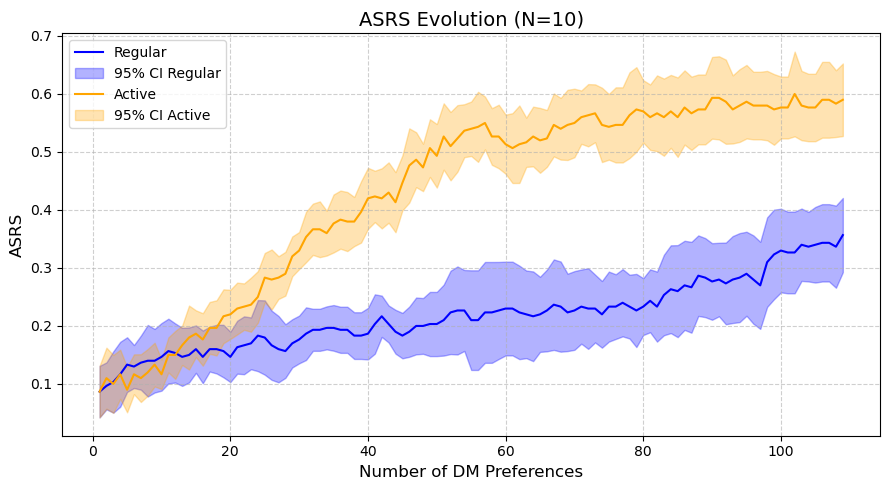

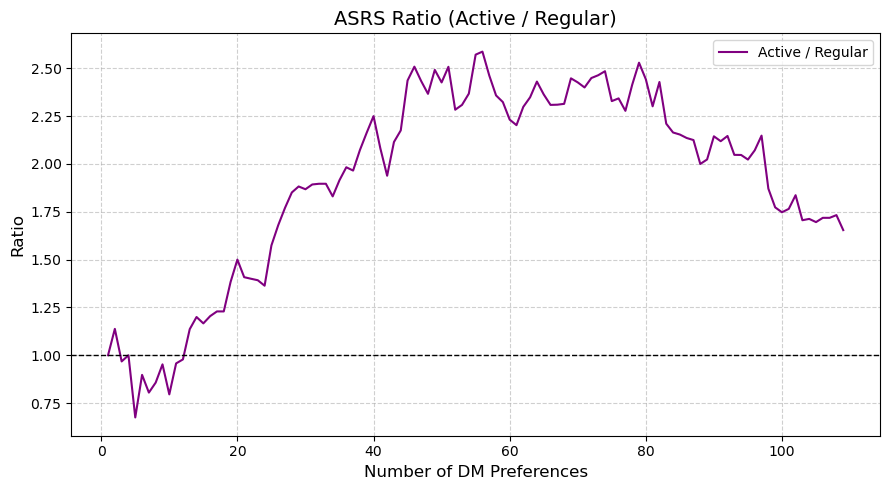

Loaded ASPS data shapes: (109, 10) (109, 10)


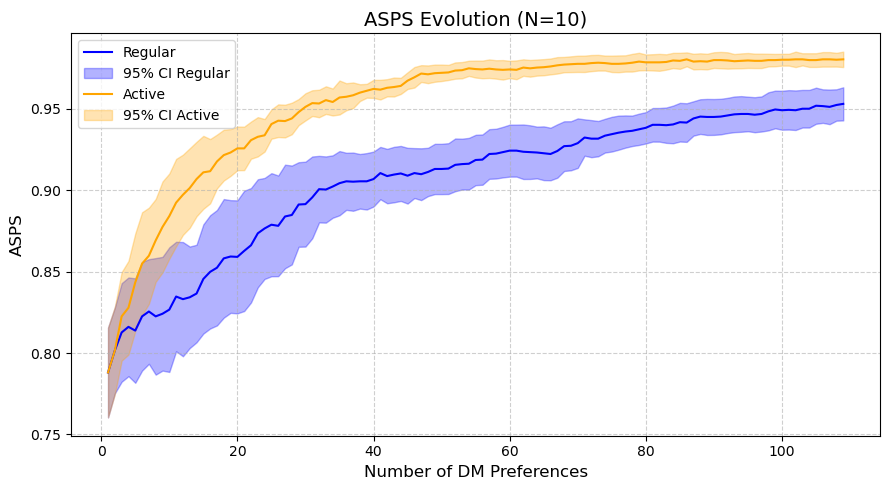

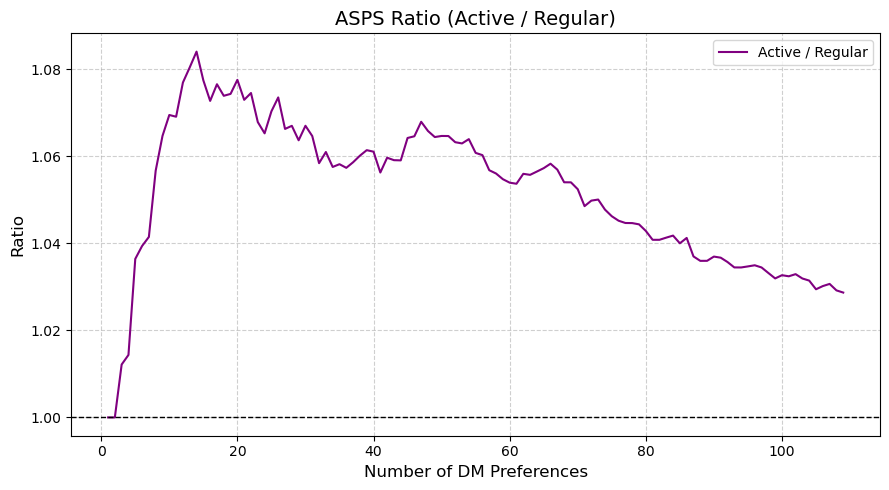

Loaded AIOS data shapes: (109, 10) (109, 10)


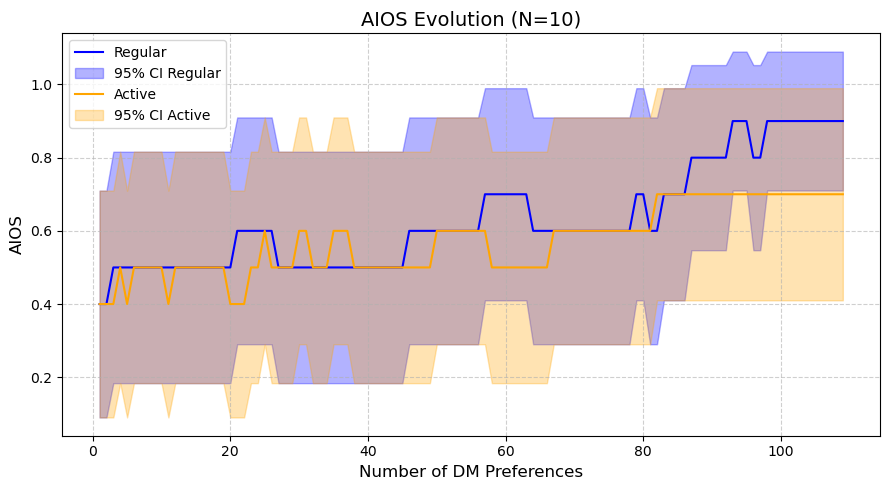

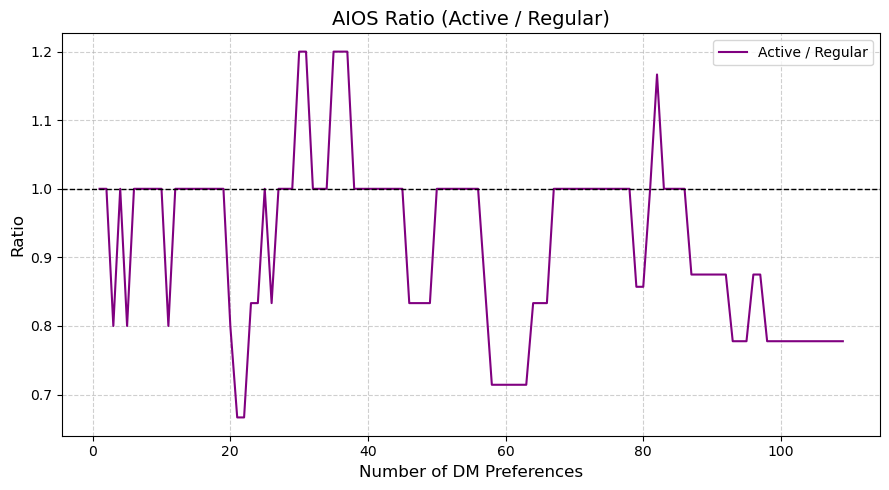

In [3]:
hm = 10
num_dm_dec = 109
flag2 = True
d_i = None
#d_i = 3
plot_metric_results('asrs', F1, F2, F3, hm, num_dm_dec, dataset_fold=dataset_fold, sub_fold=sub_fold, drop_index=d_i, save_figs=flag2, fig_name_prefix=sub_fold)
plot_metric_results('asps', F1, F2, F3, hm, num_dm_dec, dataset_fold=dataset_fold, sub_fold=sub_fold, drop_index=d_i, save_figs=flag2, fig_name_prefix=sub_fold)
plot_metric_results('aios', F1, F2, F3, hm, num_dm_dec, dataset_fold=dataset_fold, sub_fold=sub_fold, drop_index=d_i, save_figs=flag2, fig_name_prefix=sub_fold)